### Imports

In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

from cca_algorithms import bio_cca, gen_oja, msg_cca, asy_cca, bio_rrr
from CCAPyramidal import CCAPyramidal
from util import correlation_matrix, obj_error, msg_error, subspace_error, constraint_error, add_fill_lines

### Load dataset

In [57]:
# select the desired dataset and number of epochs

# dataset = 'synthetic'; epochs = 1
dataset = 'mediamill'; epochs = 3

# load dataset

X = np.load(f'datasets/{dataset}/view1.npy')
Y = np.load(f'datasets/{dataset}/view2.npy')

# dataset dimensions

x_dim = X.shape[0]
y_dim = Y.shape[0]
samples = X.shape[1]

### Offline solution

In [58]:
# Covariance matrices

Cxx = X@X.T/samples
Cyy = Y@Y.T/samples
Cxy = X@Y.T/samples

# Inverse matrices

sig_y, Uy = np.linalg.eig(Cyy)

Cyy_inv = Uy@np.diag(1./sig_y)@Uy.T

# Correlation matrix

Rxy = correlation_matrix(Cxx, Cyy, Cxy)

# SVD

u, canonical_correlations, vh = np.linalg.svd(Rxy)

### Parameters

In [73]:
trials = 1; z_dim = 2; iters = epochs*samples; training_samples = 1000

In [74]:
# Maximum of the objective

max_obj = sum(canonical_correlations[:z_dim])/2

### Asymmetric-CCA

In [75]:
# Grid

eta0_list = [.00002,.00001,.0002,.0001]
eta_decay_list = [5e-5,1e-5,5e-6,1e-6]

In [76]:
asycca_error = {}

for eta0 in eta0_list:
    
    asycca_error[eta0] = {}
    
    for eta_decay in eta_decay_list:
        
        asycca_error[eta0][eta_decay] = np.zeros((trials,iters))

In [77]:
for eta0 in eta0_list:
    
    for eta_decay in eta_decay_list:
            
        print(f'eta(t)={eta0}*max(1-{eta_decay}*t,0.1)')

        for i_trial in range(trials):

            print(f'Trial {i_trial+1} out of {trials}:')

            # Initialize Asymmetric-CCA

            def step(t):
                return eta0*max(1-eta_decay*t,0.1)

            asycca = CCAPyramidal(X, Y, k=z_dim, eta={"W": eta0, "V": eta0, "M": eta0, "Lambda": eta0, "Gamma": eta0}, steps=iters, alpha=eta_decay, mode="hierarchy")   
            asycca_Vx = np.zeros((iters,x_dim,z_dim))
            asycca_Vy = np.zeros((iters,y_dim,z_dim))

            # Run Asymmetric-CCA

            print('Running Asymmetric-CCA...')

            for i_epoch in range(epochs):

                print(f'Epoch {i_epoch+1} out of {epochs}:')

                # Random permutation of the inputs

                idx = np.random.permutation(samples)

                # Online updates

                for i_sample in range(samples):

                    i_iter = i_epoch*samples + i_sample

                    x = X[:,idx[i_sample]]
                    y = Y[:,idx[i_sample]]

                    # online updates

                    asycca.online_step(idx[i_sample], asycca.decay(i_iter))
                    asycca_Vx[i_iter], asycca_Vy[i_iter] = asycca.W, asycca.V

            # Compute error

            print('Computing errors...')

            for i_iter in range(iters):
                asycca_error[eta0][eta_decay][i_trial,i_iter] = obj_error(asycca_Vx[i_iter], asycca_Vy[i_iter], Cxx, Cyy, Cxy, max_obj)

            print(f'Average error: {np.mean(asycca_error[eta0][eta_decay][i_trial,:])}')

        # save data 

        pkl.dump(asycca_error, open(f'error/grid/asycca_{dataset}_{z_dim}-dim_error.p', 'wb'))

print('Grid search complete')

eta(t)=2e-05*max(1-5e-05*t,0.1)
Trial 1 out of 1:
Running Asymmetric-CCA...
Epoch 1 out of 3:
Epoch 2 out of 3:
Epoch 3 out of 3:
Computing errors...
Average error: 1.009402910319779
eta(t)=2e-05*max(1-1e-05*t,0.1)
Trial 1 out of 1:
Running Asymmetric-CCA...
Epoch 1 out of 3:
Epoch 2 out of 3:
Epoch 3 out of 3:
Computing errors...
Average error: 1.0212521571738866
eta(t)=2e-05*max(1-5e-06*t,0.1)
Trial 1 out of 1:
Running Asymmetric-CCA...
Epoch 1 out of 3:
Epoch 2 out of 3:
Epoch 3 out of 3:
Computing errors...
Average error: 1.0262905398042257
eta(t)=2e-05*max(1-1e-06*t,0.1)
Trial 1 out of 1:
Running Asymmetric-CCA...
Epoch 1 out of 3:
Epoch 2 out of 3:
Epoch 3 out of 3:
Computing errors...
Average error: 0.9818319647521568
eta(t)=1e-05*max(1-5e-05*t,0.1)
Trial 1 out of 1:
Running Asymmetric-CCA...
Epoch 1 out of 3:
Epoch 2 out of 3:
Epoch 3 out of 3:
Computing errors...
Average error: 1.0382154286005134
eta(t)=1e-05*max(1-1e-05*t,0.1)
Trial 1 out of 1:
Running Asymmetric-CCA...
Epoch

In [81]:
# eta0_list = [.0002,.0001]
# eta_decay_list = [1e-5,5e-6,1e-6]
eta0_list = [.0002,.0001]
eta_decay_list = [5e-6,1e-6]

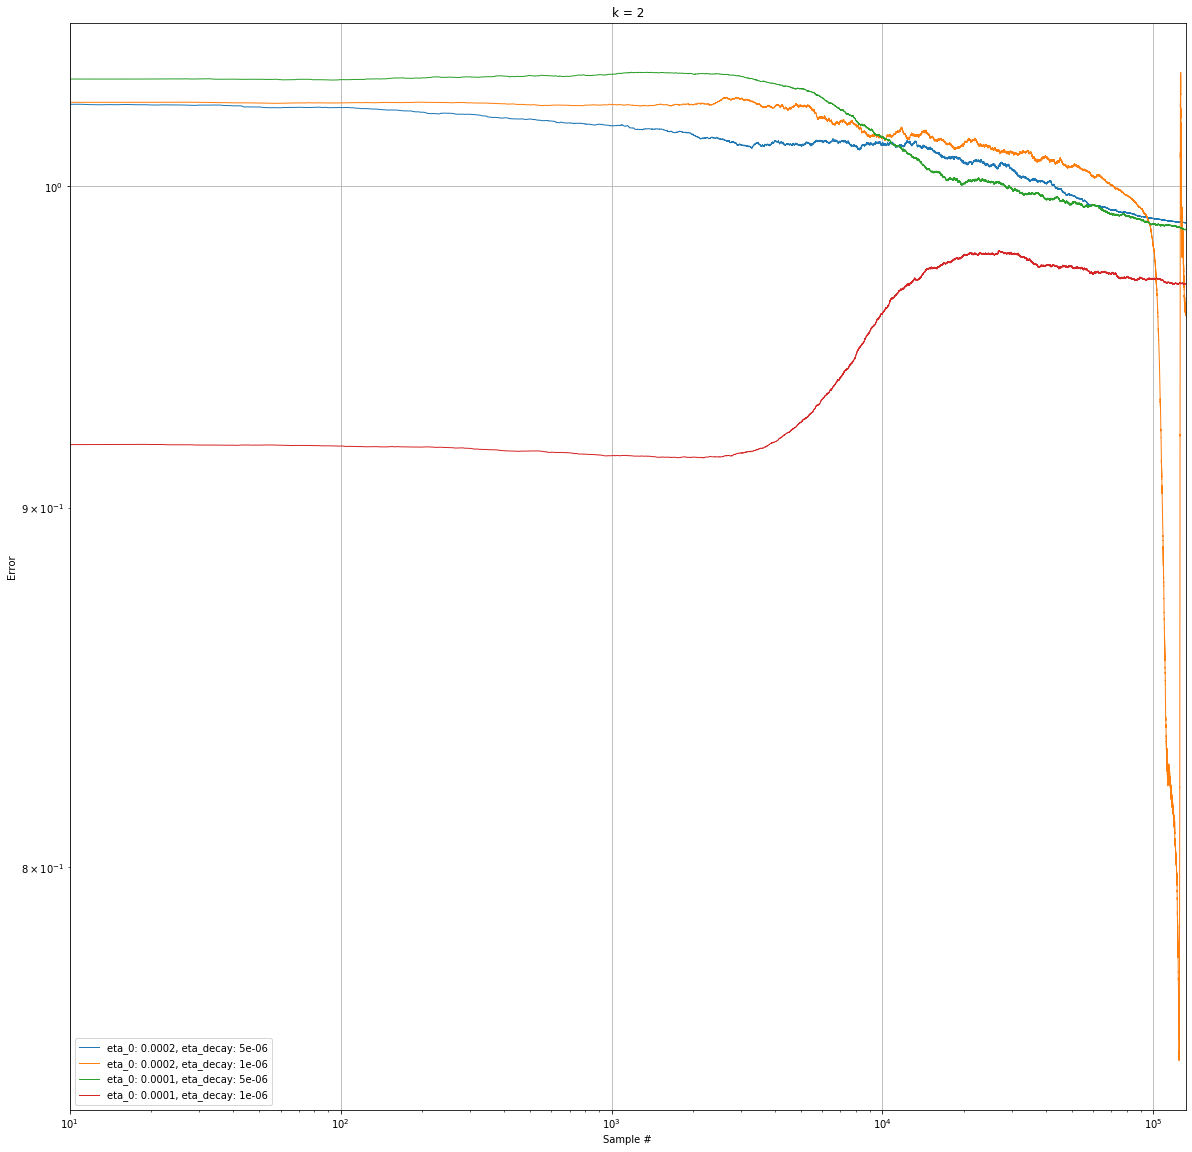

In [82]:
linewidth = 1

t = list(range(iters))

fig = plt.figure(figsize=(20,20))

ax = plt.subplot(1, 1, 1)

for eta0 in eta0_list:
    for eta_decay in eta_decay_list:
        add_fill_lines(ax, t, asycca_error[eta0][eta_decay], plot_kwargs={'ls': '-', 'lw': linewidth, 'label': f'eta_0: {eta0}, eta_decay: {eta_decay}'})

ax.loglog()

plt.title(f"k = {z_dim}")
plt.grid()
plt.legend(loc = 'lower left')
plt.xlim((1e1,iters))
plt.xlabel('Sample #')
plt.ylabel('Error')
plt.show()